In [1]:
import wandb
import pandas as pd
import numpy as np
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
api = wandb.Api()
entity, project = "s232958-danmarks-tekniske-universitet-dtu", "FT_on_meta_weighting_equal_sampling"
runs_weighting = api.runs(f"{entity}/{project}")

all_runs_list = [] 
# W&B keys (source)
Keys = ["Train Loss", "Val Loss", "Val AUROC", "Val AUPR", "val_logit_gap", "val_pos_median_logit", "val_neg_median_logit"]
# DataFrame keys (destination)
Keys_names = ["train_loss", "val_loss", "val_AUROC", "val_AUPR", "val_logit_gap", "val_pos_median_logit", "val_neg_median_logit"]

print(f"Fetching history for {len(runs_weighting)} runs...")

for run in tqdm(runs_weighting):
    # 1. Parse metadata safely
    name_parts = run.name.split("_")
    split = name_parts[0]
    strategy = "_".join(name_parts[1:]) if len(name_parts) > 1 else "default"
    
    # 2. Initialize the dictionary with lists for ALL expected columns
    run_data = {name: [] for name in Keys_names}
    run_data["epoch"] = []

    # 3. Fetch history
    history = run.scan_history()

    for row in history:
        # Check if this row contains the metrics we care about
        if any(k in row for k in Keys):
            for source_key, dest_name in zip(Keys, Keys_names):
                val = row.get(source_key)
                # Use None/NaN instead of 0 to avoid skewing data
                run_data[dest_name].append(val if val is not None else 0)
            
            # Use the W&B internal step as the epoch/time marker
            run_data["epoch"].append(row.get("_step", 0))

    # 4. Create the temp DataFrame from the populated lists
    temp_df = pd.DataFrame(run_data)
    
    # 5. Add metadata as constant columns for this specific run
    temp_df["strategy"] = strategy
    temp_df["split"] = split
    temp_df["run_id"] = run.id
    
    all_runs_list.append(temp_df)

# Final concatenation
if all_runs_list:
    Df = pd.concat(all_runs_list, ignore_index=True)
    print(f"Total rows fetched: {len(Df)}")
    print(Df.head())
else:
    print("No runs found or history empty.")

Fetching history for 25 runs...


100%|██████████| 25/25 [00:17<00:00,  1.44it/s]

Total rows fetched: 325
   train_loss  val_loss  val_AUROC  val_AUPR  val_logit_gap  \
0    0.000000  1.193580   0.558137  0.126501       0.000000   
1    0.532841  0.524076   0.643459  0.231934       0.427888   
2    0.305285  0.402445   0.644704  0.242396       0.560250   
3    0.139186  0.375275   0.611622  0.231657       0.450002   
4    0.071586  0.419319   0.637126  0.252487       0.553339   

   val_pos_median_logit  val_neg_median_logit  epoch      strategy   split  \
0              0.000000              0.000000      0  class_weight  split1   
1             -0.361391             -0.789279      1  class_weight  split1   
2             -1.172384             -1.732633      2  class_weight  split1   
3             -2.258222             -2.708223      3  class_weight  split1   
4             -3.532797             -4.086136      4  class_weight  split1   

     run_id  
0  idlyuomm  
1  idlyuomm  
2  idlyuomm  
3  idlyuomm  
4  idlyuomm  


In [3]:
Df.strategy.unique()

array(['class_weight', 'target_weight', 'class&target_weight',
       'Loss_pos_weight', 'no_weighting'], dtype=object)

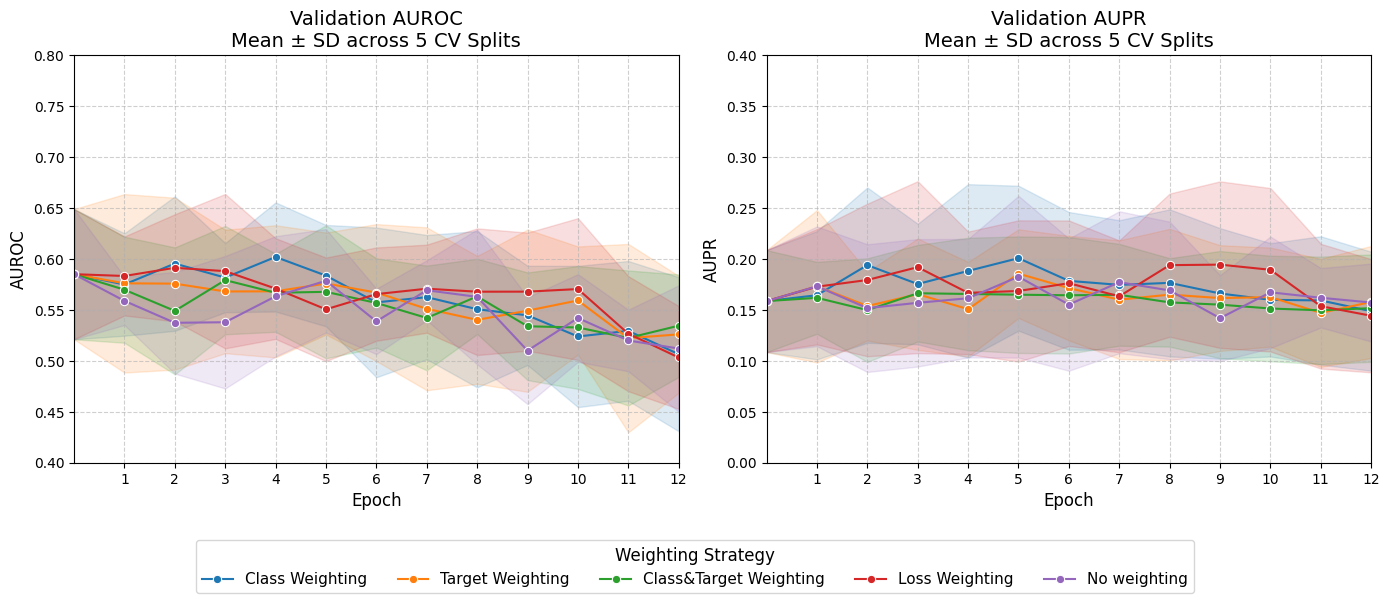

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Map labels (Ensure these match the 'strategy' column values exactly)
names = {
    "no_weighting" : "No weighting",
    "class_weight" : "Class Weighting", 
    "target_weight" : "Target Weighting",
    "class&target_weight" : "Class&Target Weighting", 
    "Loss_pos_weight" : "Loss Weighting", 
}
Df['Strategy_Label'] = Df['strategy'].map(names)

# 2. Setup Figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot AUROC
sns.lineplot(
    ax=axes[0],
    data=Df, x='epoch', y='val_AUROC', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15},
    legend=False  # Disable legend here
)
axes[0].set_title('Validation AUROC\nMean ± SD across 5 CV Splits', fontsize=14)
axes[0].set_ylim(0.40, 0.80) 
axes[0].set_xlim(0, 12)
axes[0].set_xticks(np.arange(1, 13))
axes[0].set_xlabel("Epoch", fontsize=12)  # Fixed from set_xlabel(0, 12)
axes[0].set_ylabel("AUROC", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Plot AUPR
sns.lineplot(
    ax=axes[1],
    data=Df, x='epoch', y='val_AUPR', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15},
    legend=True  # Keep one legend enabled to extract handles/labels
)
axes[1].set_title('Validation AUPR\nMean ± SD across 5 CV Splits', fontsize=14)
axes[1].set_ylim(0, 0.40)
axes[1].set_xlim(0, 12)
axes[1].set_xticks(np.arange(1, 13))
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("AUPR", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# 3. Handle the Legend Placement
# Extract handles and labels from the second plot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove() # Remove the default legend from the subplot area

# Create a single legend at the bottom of the figure
# Adjusted ncol to 5 to fit all strategies in one row
fig.legend(handles, labels, loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.01), title="Weighting Strategy", 
           fontsize=11, title_fontsize=12)

plt.tight_layout()
# Adjust subplots to make room for the legend at the bottom
plt.subplots_adjust(bottom=0.22) 

plt.show()

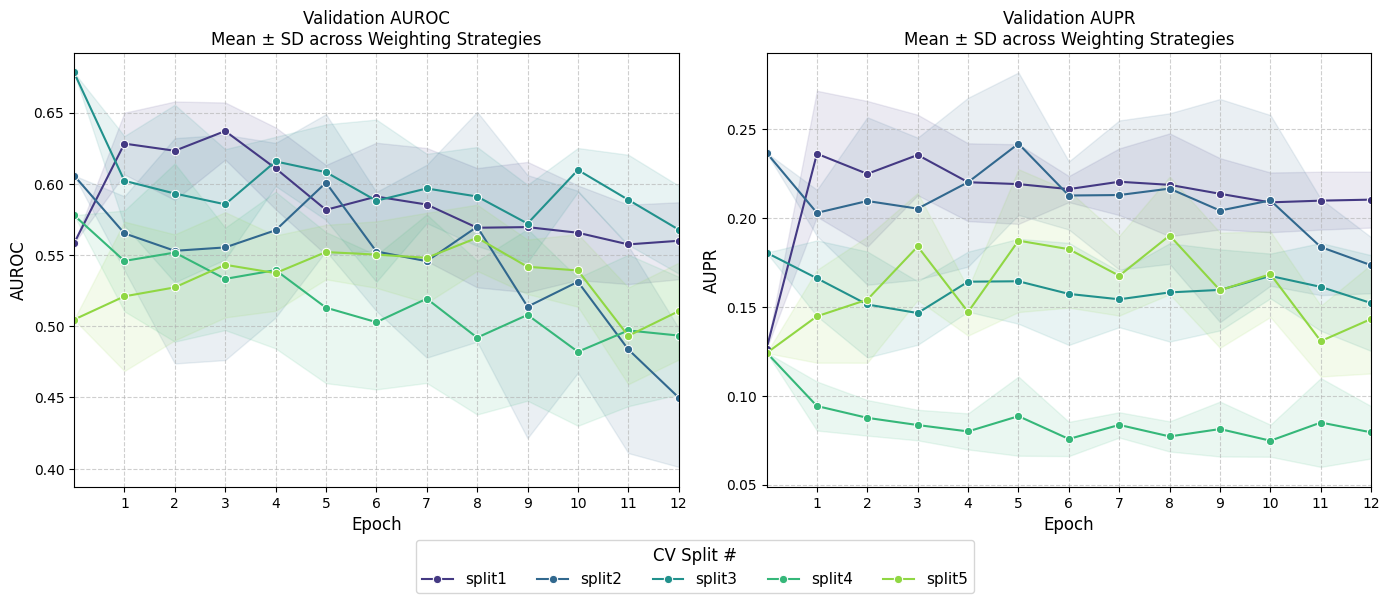

In [5]:
# Use subplots to get axes array for easier legend handling
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Plot AUROC grouped by Split
sns.lineplot(
    ax=axes[0],
    data=Df, x='epoch', y='val_AUROC', hue='split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1},
    legend=False # Disable individual legend
)
axes[0].set_title('Validation AUROC\nMean ± SD across Weighting Strategies')
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xlim(0, 12)
axes[0].set_xticks(np.arange(1, 13))
axes[0].set_xlabel("Epoch", fontsize=12)  # Fixed from set_xlabel(0, 12)
axes[0].set_ylabel("AUROC", fontsize=12)

# 2. Plot AUPR grouped by Split
sns.lineplot(
    ax=axes[1],
    data=Df, x='epoch', y='val_AUPR', hue='split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1},
    legend=True # Enable here to extract handles/labels
)
axes[1].set_title('Validation AUPR\nMean ± SD across Weighting Strategies')
axes[1].set_xlim(0, 12)
axes[1].set_xticks(np.arange(1, 13))
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("AUPR")
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("AUPR", fontsize=12)

# 3. Handle the Legend Placement
# Extract handles and labels from the second plot
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove() # Remove the default legend from inside the plot

# Create a single legend at the bottom of the figure
# Setting ncol=5 since you likely have 5 splits
fig.legend(handles, labels, loc='lower center', ncol=5, bbox_to_anchor=(0.5, -0.01), title="CV Split #", fontsize=11, title_fontsize=12)
plt.tight_layout()
# Adjust to make room for the legend
plt.subplots_adjust(bottom=0.18) 
plt.show()

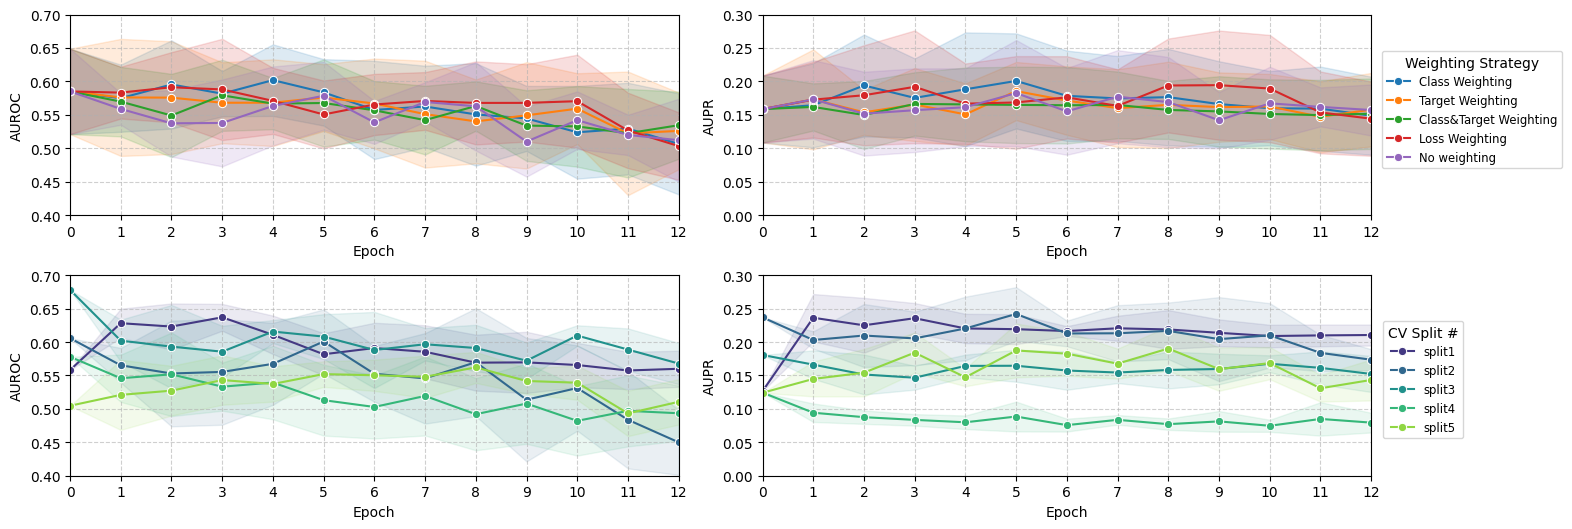

In [6]:
Df['Strategy_Label'] = Df['strategy'].map(names)

# Increase figsize height slightly to accommodate legends
fig, axes = plt.subplots(2, 2, figsize=(14, 6))

# --- ROW 1: GROUPED BY STRATEGY ---
# Enable legend=True so handles are created
sns.lineplot(
    ax=axes[0, 0], data=Df, x='epoch', y='val_AUROC', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15}, legend='brief' 
)
sns.lineplot(
    ax=axes[0, 1], data=Df, x='epoch', y='val_AUPR', hue='Strategy_Label', 
    marker='o', errorbar='sd', err_kws={'alpha': 0.15}, legend='brief' 
)

# --- ROW 2: GROUPED BY CV SPLIT ---
sns.lineplot(
    ax=axes[1, 0], data=Df, x='epoch', y='val_AUROC', hue='split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}, legend='brief'
)
sns.lineplot(
    ax=axes[1, 1], data=Df, x='epoch', y='val_AUPR', hue='split', 
    palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}, legend='brief'
)

# --- UNIFIED FORMATTING & LEGEND REMOVAL ---
for i in range(2):
    for j in range(2):
        axes[i, j].set_xlim(0, 12)
        axes[i, j].set_xticks(np.arange(0, 13))
        axes[i, j].set_xlabel("Epoch")
        axes[i, j].grid(True, linestyle='--', alpha=0.6)
        
        if j == 0: 
            axes[i, j].set_ylim(0.40, 0.70)
            axes[i, j].set_ylabel("AUROC")
        else: 
            axes[i, j].set_ylim(0, 0.30)
            axes[i, j].set_ylabel("AUPR")
        
        # KEY STEP: Extract handles/labels, then remove the legend from the axis
        # This keeps the plot clean but allows us to use fig.legend later
        if j == 0:
            if i == 0:
                h1, l1 = axes[i, j].get_legend_handles_labels()
            else:
                h2, l2 = axes[i, j].get_legend_handles_labels()
        
        axes[i, j].get_legend().remove()

# --- ADDING SHARED LEGENDS UNDER EACH ROW ---

# Shared Legend for Row 1
fig.legend(h1, l1, loc='lower center', bbox_to_anchor=(1.055, 0.65), 
           ncol=1, title="Weighting Strategy", frameon=True, fontsize = "small", title_fontsize = "medium")

# Shared Legend for Row 2
fig.legend(h2, l2, loc='lower center', bbox_to_anchor=(1.02, 0.2), 
           ncol=1, title="CV Split #", frameon=True, fontsize = "small", title_fontsize = "medium")

# Layout adjustments
plt.tight_layout(rect=[0, 0.05, 1, 0.95]) 
plt.subplots_adjust(hspace=0.3) # Space between rows for the middle legend

plt.show()

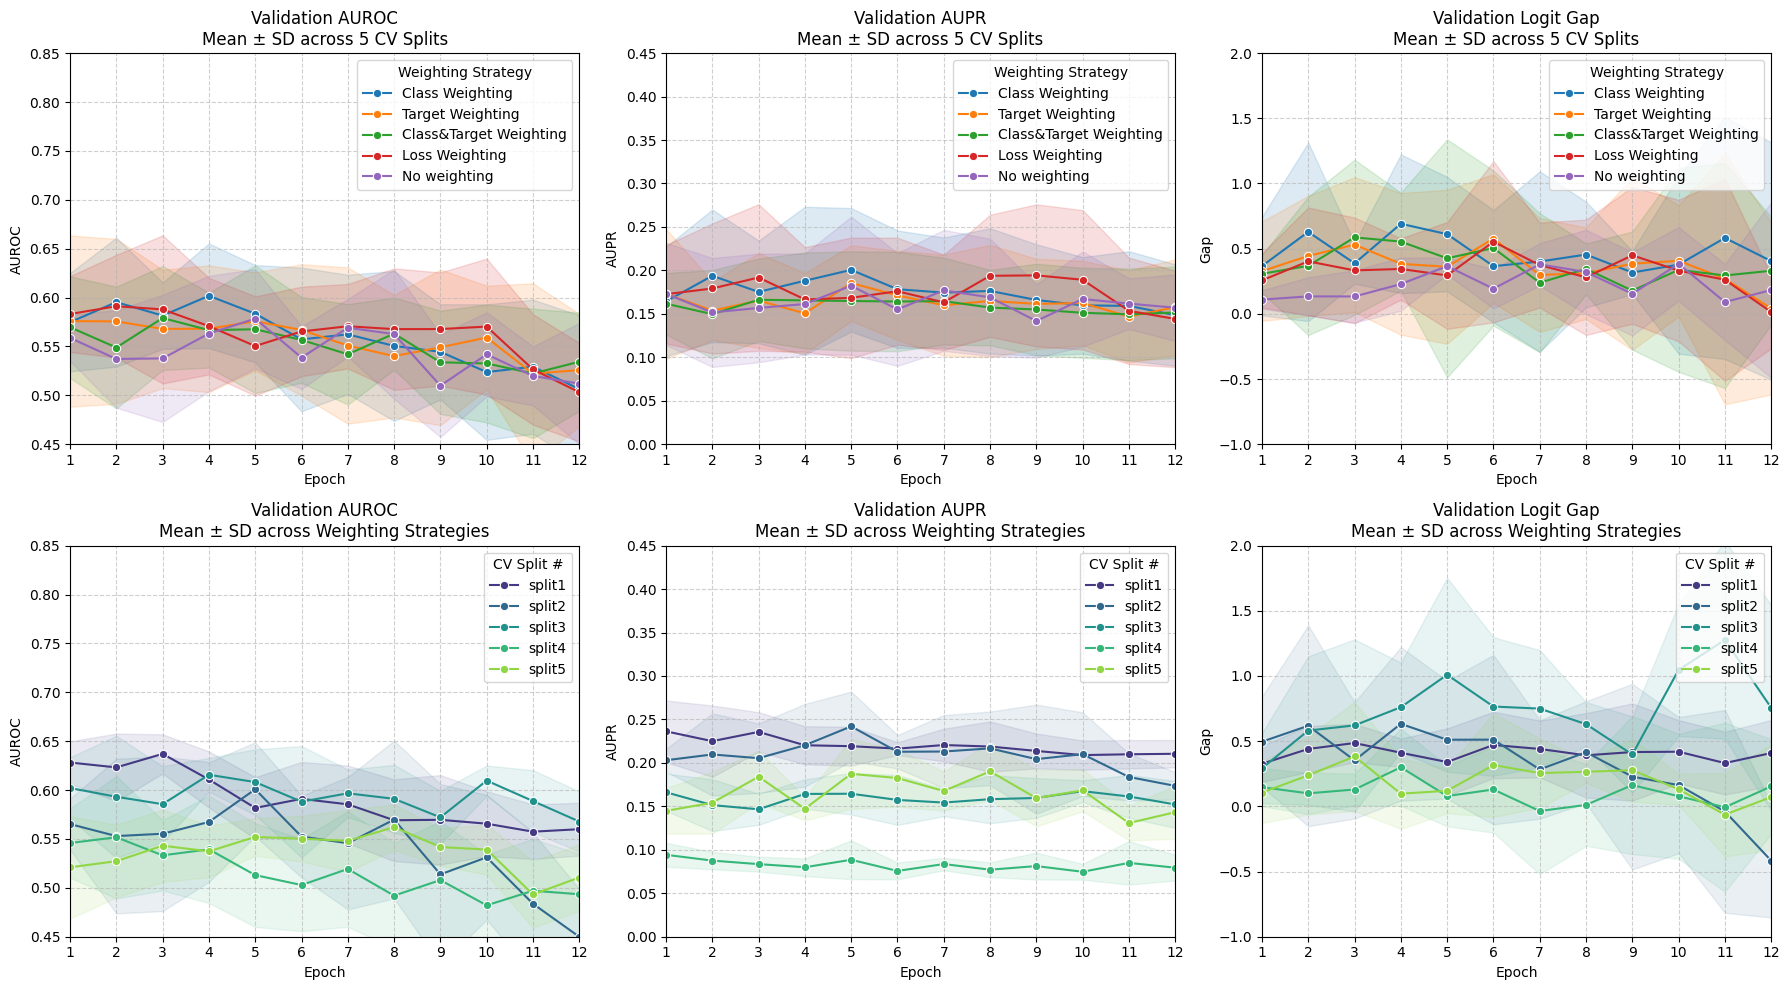

In [7]:
# Mapping Strategy Labels
Df['Strategy_Label'] = Df['strategy'].map(names)

# Create a 2x3 grid to accommodate AUROC, AUPR, and Logit Gap for both groupings
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Metrics and their corresponding Y-axis limits
metrics = ['val_AUROC', 'val_AUPR', 'val_logit_gap']
titles = ['Validation AUROC', 'Validation AUPR', 'Validation Logit Gap']
y_limits = [(0.45, 0.85), (0, 0.45), (-1.0, 2.0)]

for i, metric in enumerate(metrics):
    # --- ROW 1: Grouped by Strategy ---
    sns.lineplot(
        ax=axes[0, i], data=Df, x='epoch', y=metric, hue='Strategy_Label', 
        marker='o', errorbar='sd', err_kws={'alpha': 0.15}
    )
    axes[0, i].set_title(f'{titles[i]}\nMean ± SD across 5 CV Splits')
    axes[0, i].legend(title="Weighting Strategy", loc='upper right', fontsize='medium')

    # --- ROW 2: Grouped by CV Split ---
    sns.lineplot(
        ax=axes[1, i], data=Df, x='epoch', y=metric, hue='split', 
        palette='viridis', marker='o', errorbar='sd', err_kws={'alpha': 0.1}
    )
    axes[1, i].set_title(f'{titles[i]}\nMean ± SD across Weighting Strategies')
    axes[1, i].legend(title="CV Split #", loc='upper right', fontsize='medium')

# Unified Formatting
for ax_row in axes:
    for j, ax in enumerate(ax_row):
        ax.set_xlim(1, 12)
        ax.set_xticks(np.arange(1, 13))
        ax.set_xlabel("Epoch")
        ax.set_ylabel(titles[j].split()[-1]) # Extracts AUROC, AUPR, or Gap
        ax.set_ylim(y_limits[j])
        ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

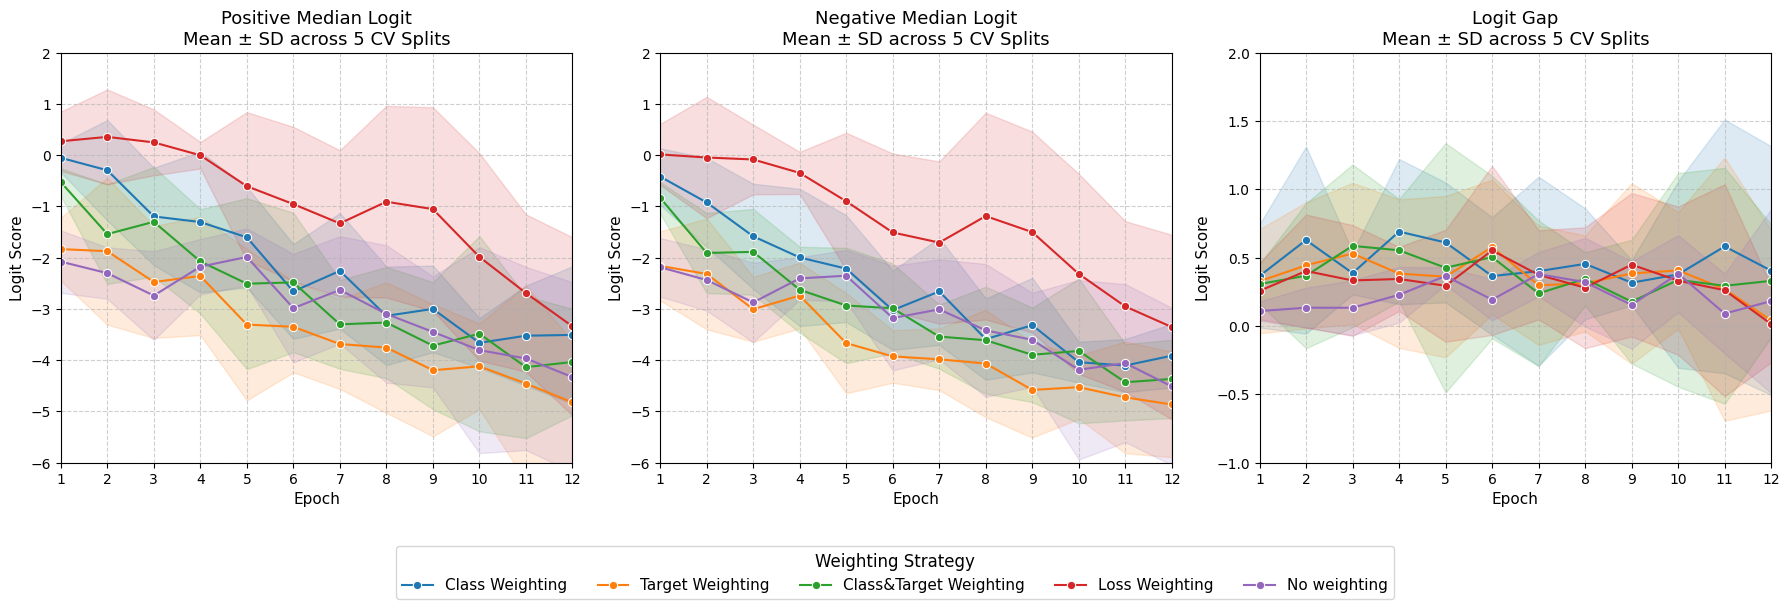

In [8]:
# 1. Define the metrics to plot
logit_metrics = ['val_pos_median_logit', 'val_neg_median_logit', 'val_logit_gap']
logit_titles = ['Positive Median Logit', 'Negative Median Logit', 'Logit Gap']

# 2. Setup Figure and Axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for i, metric in enumerate(logit_metrics):
    ax = axes[i]
    
    # Plotting grouped by Strategy
    sns.lineplot(
        ax=ax,
        data=Df, x='epoch', y=metric, hue='Strategy_Label', 
        marker='o', errorbar='sd', err_kws={'alpha': 0.15},
        legend=(True if i == 0 else False) # Keep legend on first plot temporarily to extract
    )
    
    ax.set_title(f'{logit_titles[i]}\nMean ± SD across 5 CV Splits', fontsize=13)
    ax.set_xlim(1, 12)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xlabel("Epoch", fontsize=11)
    ax.set_ylabel("Logit Score", fontsize=11)
    ax.grid(True, linestyle='--', alpha=0.6)
    
    # Apply specific y-limits
    if i < 2:
        ax.set_ylim(-6, 2) 
    else:
        ax.set_ylim(-1, 2) # Widened upper limit for the gap (Pos - Neg)

# 3. Handle the Legend Placement
# Extract handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove() # Remove from the subplot area

# Create a single legend at the bottom of the figure
fig.legend(handles, labels, loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.02), title="Weighting Strategy", 
           fontsize=11, title_fontsize=12)

plt.tight_layout()
# Adjust subplots to make room for the legend at the bottom
plt.subplots_adjust(bottom=0.22) 
plt.show()

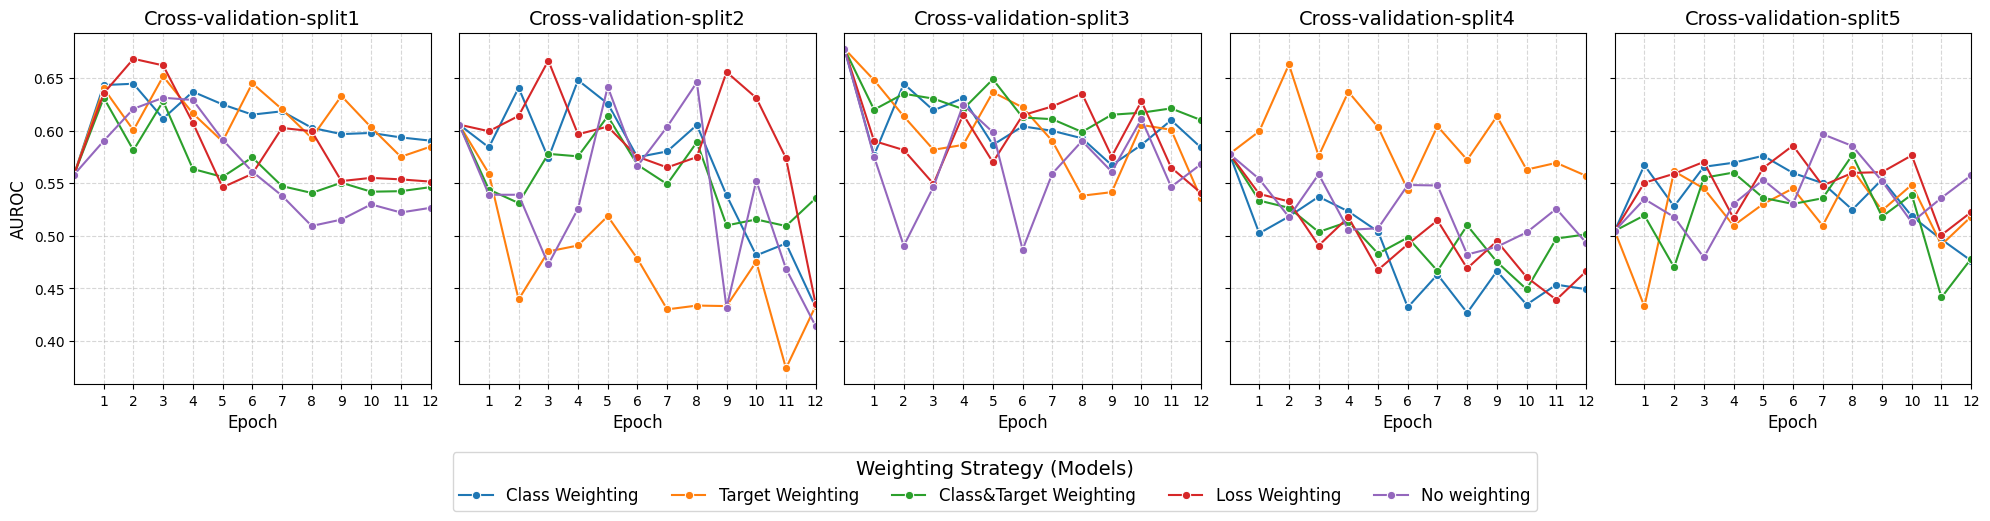

In [9]:
# 1. Setup Figure: 1 row, 5 columns (one for each Split)
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Define the metric to compare
metric_to_plot = 'val_AUROC' 
splits = sorted(Df['split'].unique())

for i, split_id in enumerate(splits):
    ax = axes[i]
    
    # Filter data for the specific split
    split_data = Df[Df['split'] == split_id]
    
    # Plot each strategy as a different line
    sns.lineplot(
        ax=ax,
        data=split_data, 
        x='epoch', 
        y=metric_to_plot, 
        hue='Strategy_Label',
        marker='o',
        legend=(True if i == 0 else False) # Legend only on the first for extraction
    )
    
    ax.set_title(f'Cross-validation-{split_id}', fontsize=14)
    ax.set_xlim(0, 12)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xlabel("Epoch", fontsize=12)
    if i == 0:
        ax.set_ylabel("AUROC", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# 2. Shared Legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()

fig.legend(handles, labels, loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.05), title="Weighting Strategy (Models)", 
           fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)

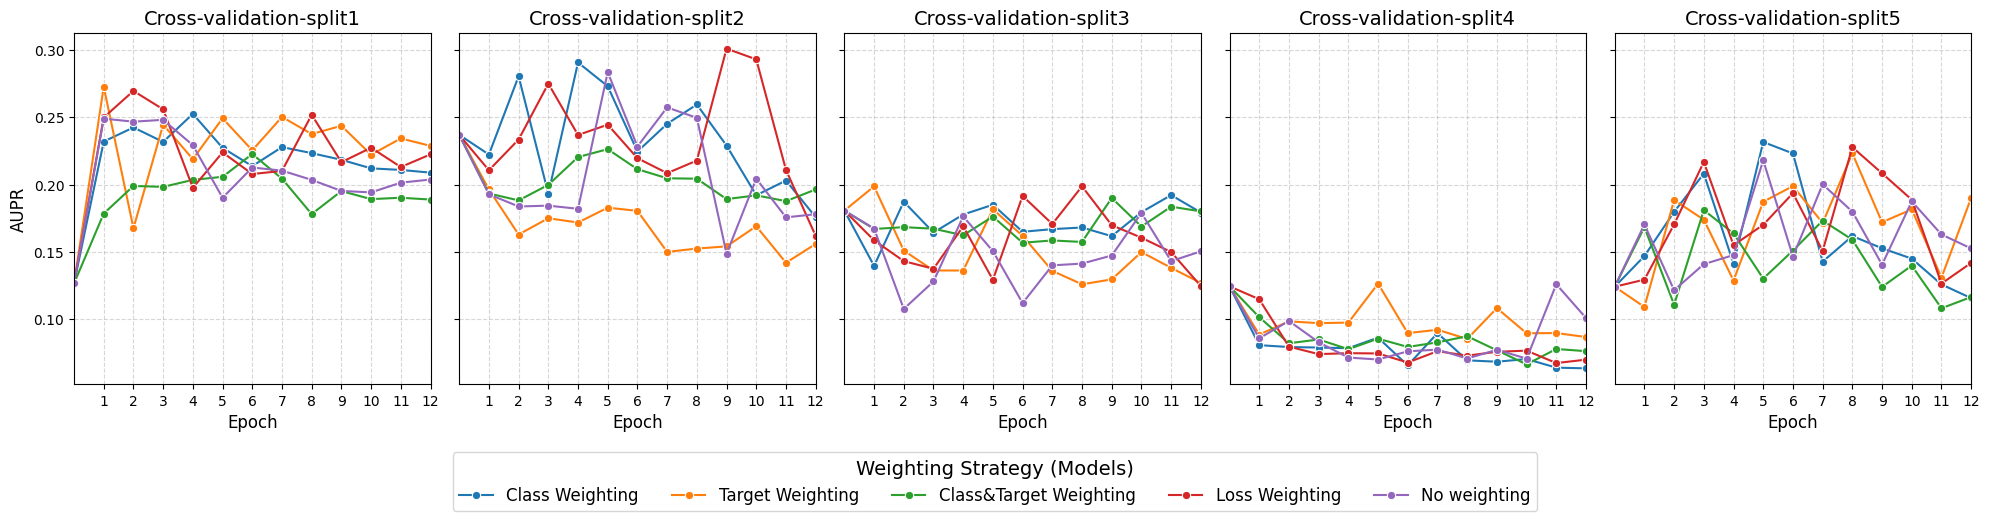

In [10]:
# 1. Setup Figure: 1 row, 5 columns (one for each Split)
fig, axes = plt.subplots(1, 5, figsize=(20, 5), sharey=True)

# Define the metric to compare
metric_to_plot = 'val_AUPR' 
splits = sorted(Df['split'].unique())

for i, split_id in enumerate(splits):
    ax = axes[i]
    
    # Filter data for the specific split
    split_data = Df[Df['split'] == split_id]
    
    # Plot each strategy as a different line
    sns.lineplot(
        ax=ax,
        data=split_data, 
        x='epoch', 
        y=metric_to_plot, 
        hue='Strategy_Label',
        marker='o',
        legend=(True if i == 0 else False) # Legend only on the first for extraction
    )
    
    ax.set_title(f'Cross-validation-{split_id}', fontsize=14)
    ax.set_xlim(0, 12)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xlabel("Epoch", fontsize=12)
    if i == 0:
        ax.set_ylabel("AUPR", fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)

# 2. Shared Legend at the bottom
handles, labels = axes[0].get_legend_handles_labels()
axes[0].get_legend().remove()

fig.legend(handles, labels, loc='lower center', ncol=5, 
           bbox_to_anchor=(0.5, -0.05), title="Weighting Strategy (Models)", 
           fontsize=12, title_fontsize=14)

plt.tight_layout()
plt.subplots_adjust(bottom=0.22)

In [40]:
Df

,train_loss,val_loss,val_AUROC,val_AUPR,val_logit_gap,val_pos_median_logit,val_neg_median_logit,epoch,strategy,split,run_id,Strategy_Label
0,0.000000,1.193580,0.558137,0.126501,0.000000,0.000000,0.000000,0,class_weight,split1,idlyuomm,Class Weighting
1,0.532841,0.524076,0.643459,0.231934,0.427888,-0.361391,-0.789279,1,class_weight,split1,idlyuomm,Class Weighting
2,0.305285,0.402445,0.644704,0.242396,0.560250,-1.172384,-1.732633,2,class_weight,split1,idlyuomm,Class Weighting
3,0.139186,0.375275,0.611622,0.231657,0.450002,-2.258222,-2.708223,3,class_weight,split1,idlyuomm,Class Weighting
4,0.071586,0.419319,0.637126,0.252487,0.553339,-3.532797,-4.086136,4,class_weight,split1,idlyuomm,Class Weighting
...,...,...,...,...,...,...,...,...,...,...,...,...
320,0.233232,0.431279,0.585470,0.179836,0.313160,-4.257707,-4.570867,8,no_weighting,split5,rza9os17,No weighting
321,0.204086,0.403319,0.552059,0.140453,0.594377,-3.079030,-3.673407,9,no_weighting,split5,rza9os17,No weighting
322,0.174878,0.550338,0.512821,0.187464,0.223132,-5.541941,-5.765073,10,no_weighting,split5,rza9os17,No weighting
323,0.138279,0.519037,0.536131,0.162895,0.033843,-5.279332,-5.313174,11,no_weighting,split5,rza9os17,No weighting


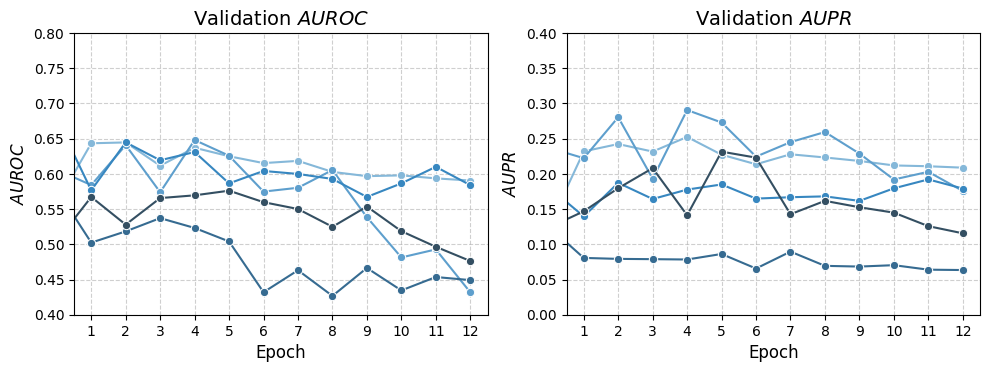

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Setup the figure
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Define a palette with 5 distinct shades of blue
# "Blues_d" provides darker, more visible shades compared to the standard "Blues"
blue_palette = sns.color_palette("Blues_d", n_colors=5)

# 2. Plot AUROC
sns.lineplot(
    ax=axes[0],
    data=Df[Df.strategy=="class_weight"], 
    x='epoch', y='val_AUROC', 
    hue='split', 
    palette=blue_palette,
    marker='o', 
    errorbar=('sd'), # Replaced err_kws for modern Seaborn compatibility
    err_style='band',
    legend=False
)
axes[0].set_title('Validation $AUROC$', fontsize=14)
axes[0].set_ylim(0.40, 0.80) 
axes[0].set_xlim(0.5, 12.5)
axes[0].set_xticks(np.arange(1, 13))
axes[0].set_xlabel("Epoch", fontsize=12)
axes[0].set_ylabel("$AUROC$", fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# 3. Plot AUPR
sns.lineplot(
    ax=axes[1],
    data=Df[Df.strategy=="class_weight"], 
    x='epoch', y='val_AUPR', 
    hue='split', 
    palette=blue_palette,
    marker='o', 
    errorbar=('sd'),
    err_style='band',
    legend=True
)
axes[1].set_title('Validation $AUPR$', fontsize=14)
axes[1].set_ylim(0, 0.40)
axes[1].set_xlim(0.5, 12.5)
axes[1].set_xticks(np.arange(1, 13))
axes[1].set_xlabel("Epoch", fontsize=12)
axes[1].set_ylabel("$AUPR$", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# 4. Refine Legend and Layout
handles, labels = axes[1].get_legend_handles_labels()
axes[1].get_legend().remove()

# Single legend for the CV Splits
# fig.legend(handles, labels, loc='lower center', ncol=5, 
#            bbox_to_anchor=(0.5, 0.02), title="Cross-Validation Split", 
#            fontsize=11, title_fontsize=12)

plt.tight_layout()
plt.subplots_adjust(bottom=0.20) 

# Save the figure as per requirements
plt.savefig('cv_splits_blue_performance.png')